<a href="https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/notebooks/3-Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results

##  Goal

In this notebook we provide codes to reproduce the main results in the article, which includes the validation of the trained models and benchmarking against Bayesian inference protocols.

## Imports

In [5]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from random import *
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Setup and Requirements

### Colab setup

If this notebook is run online in Google Colab, we:
- Download the repository from GitHub.
- Install the custom pacakge

In [6]:
# Find out if this notebook is running in Google Colab
isColab= 'google.colab' in str(get_ipython())

# Download repository if we are in Colab and install "paramest_nn" package
if isColab:
  print('We are running in Colab. Cloning repository.')
  # Download the repository (necessary to access functions in /src folder)
  ! git clone https://github.com/CarlosSMWolff/ParamEst-NN

  print('Repository downloaded.')
  ! mv ParamEst-NN/* . && rm -r ParamEst-NN

  print('Installing paramest_nn package')
  ! pip install -e .

### Import custom packages + Qutip

In [7]:
from paramest_nn.quantum_tools import *
from qutip import *

### Define data path

In [8]:
# specify the data path
datapath = '../data/'

# if running in Colab, remove the "../"
if isColab:
    datapath = datapath.split("../")[1]

Create data folder in the datapath if not already present

In [9]:
create_directory(datapath)

Folder already exists.


### Populate data folder with required data

This notebook requires the following populated folders

- `[datapath]/validation-trajectories/`
- `[datapath]/models/`
- `[datapath]/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest`

#### Option #1: Downloading the data

The data that was used for the results shown in the paper can be downloaded from [Zenodo](https://zenodo.org/).
You can choose to download this data automatically by setting

 ```python
 download_required = True
 ```
 
  in the following cell. 
This will be done automatically if this notebook is run in Google Colab.


In [10]:
download_required = False

if isColab:
    download_required = True

##### Download links (Mirror 1 - Dropbox)

In [11]:
url_download_validation_trajs = "https://www.dropbox.com/scl/fi/rvpg0lmyxoqt94qu510ws/validation-trajectories.zip?rlkey=3xhp5nh4ul5ekn43xchszrqu5&dl=0"
url_download_models = "https://www.dropbox.com/scl/fi/3u8scm7vq22s9qvb1b0jo/models.zip?rlkey=qn2xtzjjwx5x57caokxbjexj5&dl=0"
url_download_results_cache = "https://www.dropbox.com/scl/fi/s31ijcmv1a7iu61y8c4sa/results_cache.zip?rlkey=o7jhr98mpzjo1vmtp4q1e06m6&dl=0"

##### Download links (Mirror 2 - Zotero)

Uncomment the following cell if the Dropbox links in Mirror 1 are not operative. 

Hosting of this data in Zenodo is guaranteed, although download times might be slower

In [12]:
# url_download_validation_trajs = "https://www.dropbox.com/scl/fi/rvpg0lmyxoqt94qu510ws/validation-trajectories.zip?rlkey=3xhp5nh4ul5ekn43xchszrqu5&dl=0"
# url_download_models = "https://www.dropbox.com/scl/fi/3u8scm7vq22s9qvb1b0jo/models.zip?rlkey=qn2xtzjjwx5x57caokxbjexj5&dl=0"
# url_download_results_cache = "https://www.dropbox.com/scl/fi/s31ijcmv1a7iu61y8c4sa/results_cache.zip?rlkey=o7jhr98mpzjo1vmtp4q1e06m6&dl=0"

##### Download data
You may want to go and grab a coffee ☕️

In [13]:
if download_required == True:
    ! wget -q -O validation-trajectories.zip --show-progress "$url_download_validation_trajs" && unzip -q validation-trajectories.zip -d "$datapath" &&  rm validation-trajectories.zip
    ! wget -q -O models.zip --show-progress "$url_download_models" && unzip -q models.zip -d "$datapath" &&  rm models.zip
    ! wget -q -O results_cache.zip --show-progress "$url_download_results_cache" && unzip -q results_cache.zip -d "$datapath" &&  rm results_cache.zip

#### Option #2: Generate data 

The folders can be populated with your own data as follows.

- `[datapath]/validation-trajectories/`:     Populated by running the notebook [1-Trajectories_generation.ipynb](https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/1-Trajectories_generation.ipynb)

- `[datapath]/models/`: Populated by running the notebook [2-Training.ipynb](https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/2-Training.ipynb)

- `[datapath]/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest`: Populated by running the script `uniform_2d.py`

### Number of CPUs (Qutip)

In order to benefit from parallelization, we set up the number of available CPUs for Qutip to use

In [14]:
import multiprocessing
num_cpus = multiprocessing.cpu_count()

# We set the maximum number of cpus available to Qutip as the total number-1
max_cpus=num_cpus-1
qutip.settings.num_cpus = max_cpus
print(f"Number of CPUs available for Qutip: {max_cpus}")

Number of CPUs available for Qutip: 11


## Load validation trajectories

### Data for 1D estimation

In [15]:
jumpsSetDelta = np.load(datapath+"validation-trajectories/1D-delta/validation-trajectories-1D-delta-nsets-10000.npy")
deltalist = np.load(datapath+"validation-trajectories/1D-delta/validation-deltas-1D-delta-nsets-10000.npy")
ndelta = len(deltalist)

gamma = 1
omega =1

### Data for 2D estimation

In [16]:
path_param = datapath+"validation-trajectories/2D-delta-omega/validation-deltas-2D-delta-omega-nsets-10000.npy"
path_tau = datapath+"validation-trajectories/2D-delta-omega/validation-trajectories-2D-delta-omega-nsets-10000.npy"

paramlist = np.load(path_param)
jumpsSetParams = np.load(path_tau)
nparams =  len(paramlist)

## Define validation functions

In [17]:
def validate_model_1D_Delays(model,nsets = 10000,jumpsSetDelta=jumpsSetDelta,deltalist=deltalist, progress_bar = True, taumax = 100):

    ndelta = len(deltalist)
    jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]


    if progress_bar == True:
        def bar(x):
            return tqdm(x)
    else:
        def bar(x):
            return x
    
    MSE_list = []
    Estimation_list = []

    for i_delta in bar(range(ndelta)): #Bucle sobre deltas
    
        delta=deltalist[i_delta]
        
        trajectory_matrix = jumpsSetDeltaList[i_delta]
        Delta_pred = np.zeros(nsets,float)

        # Identify if we are dealing with a RNN by the input size, and reshape input matrix accordingly
        if len(model.input.shape)==3:
            trajectory_matrix = np.expand_dims(trajectory_matrix, axis = -1)
        #Delta_pred=model.predict(trajectory_matrix,verbose=0)
        Delta_pred=model(trajectory_matrix)
        
        MSE_NN = np.mean((Delta_pred-delta)**2)

        MSE_list.append(MSE_NN)
        Estimation_list.append(Delta_pred)

    return np.asarray(MSE_list), np.asarray(Estimation_list)

def validate_model_2D_Delays(model,nsets = 10000,jumpsSetParams=jumpsSetParams,paramlist=paramlist, progress_bar = True):
    nparams = len(paramlist)
    jumpsSetList = [jumpsSet[:nsets] for jumpsSet in jumpsSetParams]

    if progress_bar == True:
        def bar(x):
            return tqdm(x)
    else:
        def bar(x):
            return x  
    MSE_NN_params = []

    for i_param in bar(range(nparams)): # Loop over parameter pairs (delta,Omega)
        delta=paramlist[i_param][0]
        omega = paramlist[i_param][1]
        
        trajectory_matrix = jumpsSetList[i_param]
       
        # ============ PREDICTION ==============================
        Param_pred=np.reshape(model(trajectory_matrix),(nsets,2))
        Delta_pred = Param_pred[:,0]
        Omega_pred = Param_pred[:,1]
        # =====================================================


        diff_delta=(Delta_pred-delta)
        diff_omega=(Omega_pred-omega)
        MSE_NN = np.mean(diff_delta**2) + np.mean(diff_omega**2)

        
        MSE_NN_params.append(MSE_NN)

    MSE_NN_params = np.asarray(MSE_NN_params)
    return MSE_NN_params


## Figure 2: Classical and quantum data

### Figure 2(a-b): Evolution of a quantum trajectory and the associated posterior of $\Delta$

Create function to define a two-level system (TLS) model class (see src/bayesian.py)

Generate a list of models with different $\Delta$ values for a brute-force calculation of the Bayesian posterior

In [16]:
delta_min = 1e-3; delta_max = 4.; ndelta_Bayes = 400;

delta_grid = np.linspace(delta_min,delta_max, ndelta_Bayes)
delta_grid_Bayes = delta_grid

model_list = [create_TLS_model(delta,omega,gamma) for delta in delta_grid_Bayes]

Fix the seed of the simulation (for reproducibility)

In [17]:
seed = 44

Generate an example trajectory

In [18]:
delta = 2.; gamma = 1.; omega = 1.
model_TLS =  create_TLS_model(delta,omega,gamma)

ntraj = 1; tfin = 100.; nt = 50000; tlist = np.linspace(0.,tfin,nt)
tau_list, pops = model_TLS.simulateTrajectories(tfin=tfin, ntraj=ntraj, tlistexp = tlist, seed = seed)

idx = 0 
taus = tau_list[idx]
pop_time = pops[idx]

Compute the posterior along the evolution of the trajectory (evaluating the likelihood over the list of different $\Delta$ values)

In [19]:
ntBayes = 400; tlistBayes = np.linspace(0.,tfin,ntBayes)

prob_delta_time = np.asarray([np.real(generate_prob_from_model_list(data = taus[np.cumsum(taus)<tfin], model_list = model_list, tfin = tfin)[:,-1]) for tfin in tqdm(tlistBayes)])

  0%|          | 0/400 [00:00<?, ?it/s]

/Users/carlos/Dropbox/La-Caixa-Junior-Leader/Fisher-information/ParamEst-NN/paramest_nn/quantum_tools.py:418: RuntimeWarning: invalid value encountered in divide
  prob_delta = likelihood_time_delta/np.sum(likelihood_time_delta,axis=0)
100%|██████████| 400/400 [00:08<00:00, 48.27it/s] 


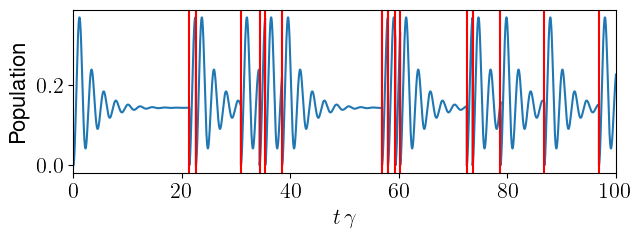

In [20]:
matrix = np.real(prob_delta_time).transpose()
aspect = 0.3

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))

c = ax
c.plot(tlist,pop_time)
plt.xlim(0,tfin)  
c.set_box_aspect(aspect)
for time in np.cumsum(taus):
    c.axvline(time, color = 'red')
c.set_xlabel('$t\, \\gamma$')
c.set_ylabel('Population')
plt.savefig("figures/fig2_a.pdf")

plt.show()

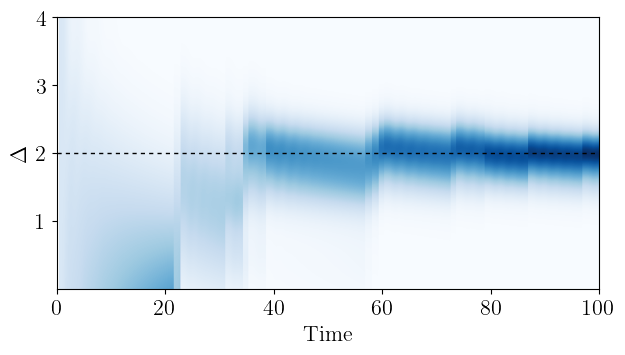

In [21]:
matrix = np.real(prob_delta_time).transpose()
aspect = 0.5

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
extent = [0,tfin, delta_min, delta_max]

c = ax
c.imshow(matrix, extent=extent, aspect = aspect*extent[1]/extent[3], cmap = "Blues" )
c.set_xlabel("$\\mathrm{Time}$"); 
c.set_ylabel("$\Delta$"); 
c.set_box_aspect(aspect)
c.axhline(delta,linewidth=1, color='black', dashes = [3., 3.])


plt.savefig("figures/fig2_b.pdf")

plt.show()

### Figure 2 (c)

In [111]:
Omega = 1
deltamin = 0.; deltamax = 10.; ndelta_w = 100; deltagrid = np.linspace(deltamin,deltamax,ndelta_w)
paramList  = [[Omega, Delta] for Delta in deltagrid]
taumax = 10.; ntau = 500;
taulist = np.linspace(0,taumax,ntau)

wtaumatrix = np.asarray([compute_waiting_time_list(params, taulist) for params in paramList])
poplist = np.asarray([compute_population_ss(params) for params in paramList])


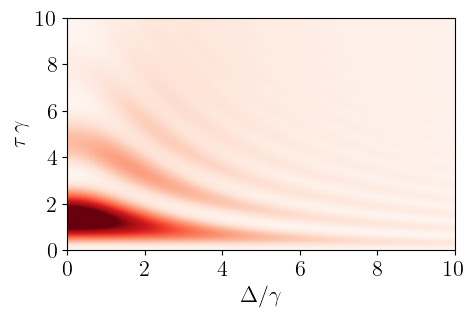

In [122]:
aspect = 0.6
matrix = wtaumatrix.T
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
extent = [deltamin, deltamax,0,taumax]

c = ax
vmax = 0.4
from matplotlib import colors
wtaunorm=colors.TwoSlopeNorm(vmin=0, vcenter=vmax/2, vmax=vmax)

pcm=c.imshow(matrix, extent=extent, aspect = aspect*extent[1]/extent[3], norm=wtaunorm,cmap="Reds", origin = 'lower' )
#fig.colorbar(pcm, ax=c,location='right')
c.set_ylabel("$\\tau\, \\gamma$"); 
c.set_xlabel("$\\Delta/\\gamma$"); 
c.set_box_aspect(aspect)

plt.savefig("figures/fig2_c.pdf")


plt.show()

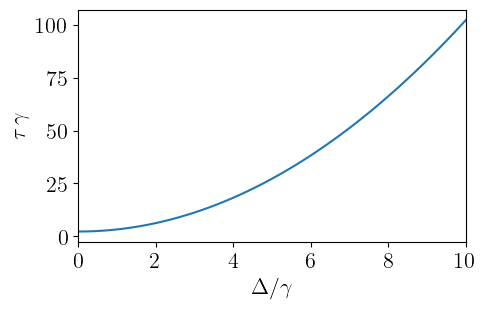

In [126]:
aspect = 0.6
matrix = wtaumatrix.T
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))

c = ax
c.plot(deltagrid,1/np.real(poplist))
plt.xlim(0,deltamax)
c.set_ylabel("$\\langle T \\rangle \\gamma/N$"); 
c.set_xlabel("$\\Delta/\\gamma$"); 
c.set_box_aspect(aspect)


c.set_ylabel("$\\tau\, \\gamma$"); 
c.set_xlabel("$\\Delta/\\gamma$"); 
c.set_box_aspect(aspect)

plt.savefig("figures/fig2_d.pdf")


plt.show()

### Figure 2(e): Histograms of time delays 

In [127]:
nsetsplot = 30
i_delta = 5

trajectories_plot=jumpsSetDelta[i_delta][:nsetsplot]

#Turn into histogram
nbins = 50
taumaxplot=10
bins = np.linspace(0,taumaxplot,nbins)

histogram_list = np.zeros([len(trajectories_plot), nbins-1])
for idx, delays in enumerate(trajectories_plot):
    histogram_list[idx] = np.histogram(delays,bins=bins)[0]
histogram_list = np.asarray(histogram_list)

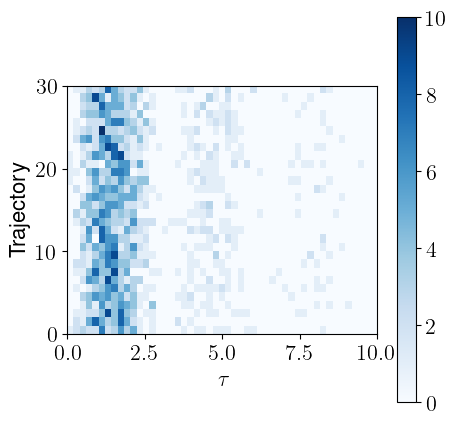

In [130]:
fig, ax = plt.subplots(figsize=(5,5))
aspect = 0.8
extent=[0,taumaxplot,0,nsetsplot]
pcm = ax.imshow(histogram_list, extent=extent, aspect = aspect*extent[1]/extent[3], cmap = "Blues" )
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Trajectory")
ax.set_box_aspect(aspect)
fig.colorbar(pcm, ax=ax,location='right')
plt.savefig("figures/fig2_e.pdf")
plt.show()

### Figure 2(d)

In [131]:
i_delta = 5
tfin_list = np.sum(jumpsSetDelta[i_delta],axis = 1)

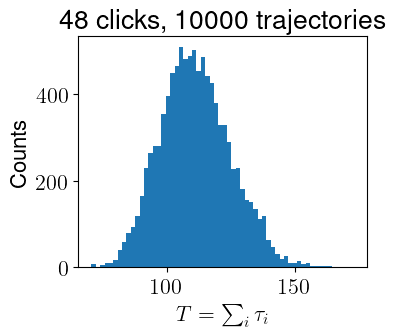

In [133]:
fix, ax = plt.subplots(figsize = (5,3))
ax.hist(tfin_list, bins = 60, density = False)
ax.set_xlabel('$T = \sum_i \\tau_i$')
ax.set_ylabel('Counts')
ax.set_box_aspect(0.8)
ax.set_title(f"48 clicks, {len(jumpsSetDelta[i_delta])} trajectories ")
plt.savefig("figures/fig2_f.pdf")
plt.show()

## Figure 3: Benchmarking models for 1D parameter estimation

### Classical estimation

In [18]:
import numpy as np

def delta_pred_TLS(T:float, Omega:float, gamma:float, n:float)-> float:
    """
    Calculate the predicted value of delta assuming that the number of clicks follows a Poissonian distribution with a mean given by the TLS population.

    Parameters:
    T: Total evolution time.
    Omega: Rabi frequency of the drive.
    gamma: Spontaneous emission rate.
    n: Number of clicks.

    Returns:
    float: Predicted delta value.
    """
    # Convert the input temperatures to complex numbers
    T = T.astype(complex)
    
    # Calculate the predicted delta using the TLS model formula
    delta = np.real(
        np.sqrt((4 * T * gamma * Omega**2 - n * (gamma**2 + 8 * Omega**2))) /
        (2 * np.sqrt(n))
    )
    
    return delta

In [19]:
njumps = jumpsSetDelta.shape[2]
nsets = jumpsSetDelta.shape[1]

MSE_Class = []
Estimation_list = []
ndelta = len(deltalist)

for i_delta in range(ndelta): # Loop over deltas
    
    delta=deltalist[i_delta]
    jumpsSet = jumpsSetDelta[i_delta]
    Delta_pred = np.zeros(nsets,float)
    # We sum over all the delays to get a list of final times
    tflist=np.sum(jumpsSet,axis =1) 
 
    for i in range(0,nsets): # Loop over sets
        n_mean=njumps
        tfinal = tflist[i]
        Delta_pred[i] = delta_pred_TLS(tfinal, omega, gamma, n_mean)

    MSE = np.mean((Delta_pred-delta)**2)
    MSE_Class.append(MSE)
    Estimation_list.append(Delta_pred)

estimationsClassical = np.asarray(Estimation_list)

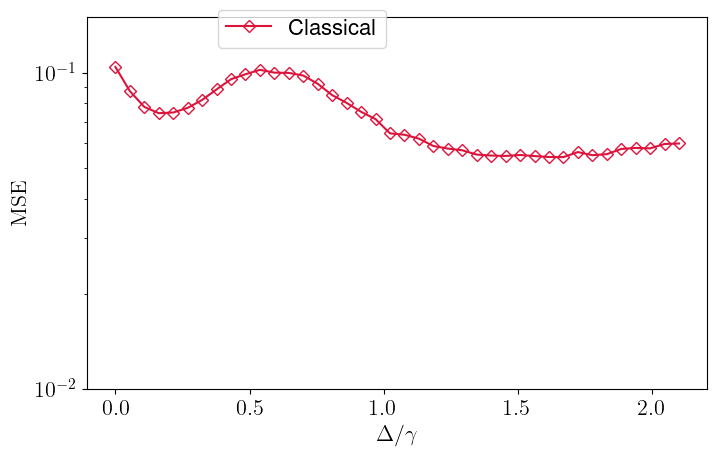

In [20]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

#### Further checks: how are the variances of photon-counting distributions?
Lets see

In [55]:
omega_sel = 1. 
i_delta = 2
delta_sel=deltalist[i_delta]

model_TLS_sel = create_TLS_model(delta_sel,omega)
taus = model_TLS_sel.simulateTrajectories(tfin = 200., ntraj=3000, progress_bar = True, num_cpus = max_cpus)

10.0%. Run time:   1.03s. Est. time left: 00:00:00:09
20.0%. Run time:   1.89s. Est. time left: 00:00:00:07
30.0%. Run time:   2.75s. Est. time left: 00:00:00:06
40.0%. Run time:   3.62s. Est. time left: 00:00:00:05
50.0%. Run time:   4.62s. Est. time left: 00:00:00:04
60.0%. Run time:   5.46s. Est. time left: 00:00:00:03
70.0%. Run time:   6.31s. Est. time left: 00:00:00:02
80.0%. Run time:   7.15s. Est. time left: 00:00:00:01
90.0%. Run time:   8.00s. Est. time left: 00:00:00:00
100.0%. Run time:   8.85s. Est. time left: 00:00:00:00
Total run time:   8.88s


In [56]:
Nlist = np.asarray([len(tau_list) for tau_list in taus])

count_list = np.bincount(Nlist)
pN = count_list/np.sum(count_list)
n_domain = np.arange(0, np.max(Nlist)+1)

n2mean = np.dot(n_domain**2, pN)
nmean = np.dot(n_domain, pN)
Qresult = (n2mean - nmean**2)/nmean

print(f" Q is {Qresult}")

 Q is 0.7227194565700489


In [57]:
def poissonian(N,n_mean):
    return exp(-n_mean)*n_mean**N/np.math.factorial(N)

pN_poisson = np.asarray([poissonian(N, nmean) for N in n_domain])

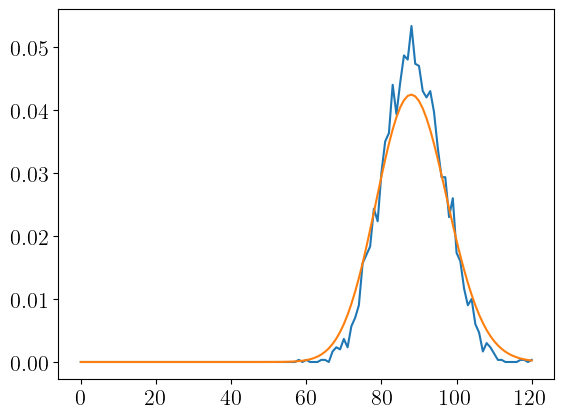

In [58]:
plt.plot(n_domain, pN)
plt.plot(n_domain, pN_poisson )
plt.show()

#### $P(T|N)$

In [74]:
def compute_tau2(Delta, Omega =1., gamma = 1.):
    '''
    Returns the variance of the random variable taus
    '''
    numerator = ((gamma**2 + 4 * Delta**2)**2 - 8 * (gamma**2 - 12 * Delta**2) * Omega**2 + 64 * Omega**4)
    denominator = 16 * gamma**2 * Omega**4
    result = numerator / denominator
    return result

def calculate_Ptau_gaussian(tau,Delta, gamma=1., Omega=1., N=48):
    nmean = compute_population_ss([Omega, Delta])
    taumean = 1/(nmean*gamma)
    tau2mean = compute_tau2(delta, Omega)
    sigma2 = tau2mean/N
    sigma = np.sqrt(sigma2)

    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*((tau-taumean)/sigma)**2)

In [118]:
i_delta = 21
delta=deltalist[i_delta]
jumpsSet = jumpsSetDelta[i_delta]
Delta_pred_mean = np.zeros(nsets,float)
Delta_pred_max = np.zeros(nsets,float)

# We sum over all the delays to get a list of final times
# Update: I divide upon the number of clicks
tflist=np.sum(jumpsSet,axis =1)[:nsets]/48
 

In [121]:
nbins = 100
t_hist, t_bins = np.histogram(tflist, bins = nbins, density = True)
t_axis = t_bins[:nbins]

gamma = 1
Omega = 1
pt_list = np.asarray([calculate_Ptau_gaussian(tau,delta, gamma=1., Omega=1., N=48) for tau in t_axis])

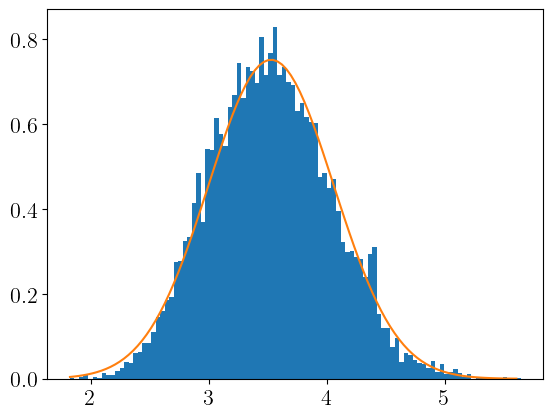

In [123]:
plt.hist(tflist, bins = nbins, density=True)
plt.plot(t_axis, pt_list)
plt.show()

#### Bayesian probability calculator

In [128]:
def MMSE_MLE_estimator(T,Omega, Delta_list, gamma =1,  N=48, return_prob = False):
    ''' 
    Returns estimator based on the mean of the posterior distribution (minimum mean square error (MMSE) estimator)
    '''
    # PT_Delta_list = np.asarray([calculate_PT(T,N,gamma,Omega, Delta) for Delta in Delta_list])
    PT_Delta_list = np.asarray([calculate_Ptau_gaussian(T/48,Delta) for Delta in Delta_list]) 
    norm = np.trapz(PT_Delta_list, Delta_list)
 
    #Posterior
    PDelta = PT_Delta_list/norm
    Delta_mean = np.trapz(PDelta*Delta_list,Delta_list)
    Delta_max = Delta_list[np.argmax(PDelta)]
    
    if return_prob==False:
        return Delta_mean, Delta_max
    else:
        return Delta_mean, Delta_max, PDelta

In [139]:
njumps = jumpsSetDelta.shape[2]
nsets =  10000

MSE_Class_Bayes_max = []
MSE_Class_Bayes_mean = []

Estimation_list_mean = []
Estimation_list_max = []

ndelta = len(deltalist)

Delta_bayes_list = np.linspace(0, 5., 200)
Omega = 1.

for i_delta in tqdm(range(ndelta)): # Loop over deltas
    
    delta=deltalist[i_delta]
    jumpsSet = jumpsSetDelta[i_delta]
    Delta_pred_mean = np.zeros(nsets,float)
    Delta_pred_max = np.zeros(nsets,float)

    # We sum over all the delays to get a list of final times
    tflist=np.sum(jumpsSet,axis =1)[:nsets] 
 
    for i in range(0,nsets): # Loop over sets
        tfinal = tflist[i]
        Delta_mean, Delta_max = MMSE_MLE_estimator(tfinal,Omega, Delta_bayes_list)
        Delta_pred_mean[i] = Delta_mean
        Delta_pred_max[i] = Delta_max

    MSE_mean = np.mean((Delta_pred_mean-delta)**2)
    MSE_max = np.mean((Delta_pred_max-delta)**2)

    MSE_Class_Bayes_max.append(MSE_max)
    MSE_Class_Bayes_mean.append(MSE_mean)

    
    Estimation_list_mean.append(Delta_pred_mean)
    Estimation_list_max.append(Delta_pred_max)

100%|██████████| 40/40 [03:19<00:00,  5.00s/it]


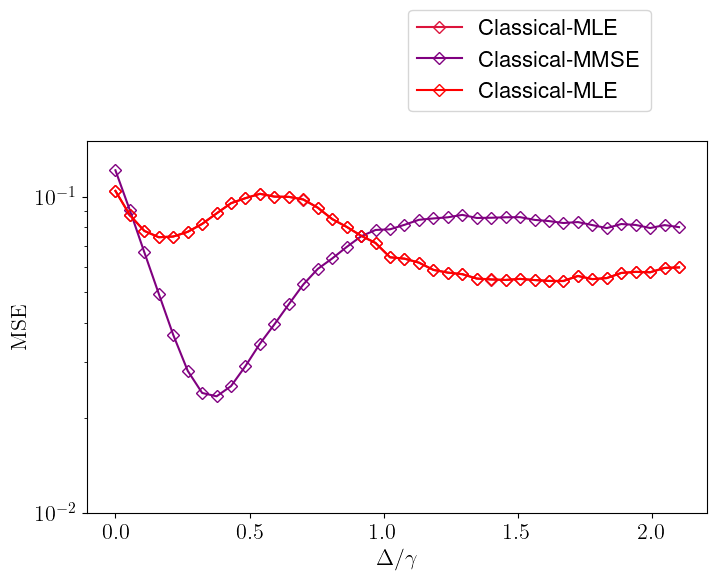

In [163]:
estimationsClassicalBayes_mean = np.asarray(Estimation_list_mean)
estimationsClassicalBayes_max = np.asarray(Estimation_list_max)


fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical-MLE", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,MSE_Class_Bayes_mean, 'D-',  label= "Classical-MMSE", color = "purple",markerfacecolor='none')
ax.plot(deltalist,MSE_Class_Bayes_max, 'D-',  label= "Classical-MLE", color = "red",markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

### Bayesian estimation

In [187]:
max_cpus=19
qutip.settings.num_cpus = max_cpus

nsets = 10000
jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]

path_cached_results_mean = datapath+'results_cache/bayesian_estimation/1D/estimationBayes1D_mean.npy'
path_cached_results_max = datapath+'results_cache/bayesian_estimation/1D/estimationBayes1D_max.npy'

if not os.path.isfile(path_cached_results_mean):
    print("Estimation not found: Computing.")

    estimate_array_delta = []

    for i_delta in tqdm(range(ndelta)): #Bucle sobre deltas


        delta=deltalist[i_delta]

        trajectory_matrix = jumpsSetDeltaList[i_delta]

        Delta_pred = np.zeros(nsets,float)
        estimate_array = parallel_map(get_estimates,trajectory_matrix)
        estimate_array_delta.append(estimate_array)

    estimate_array_delta = np.asarray(estimate_array_delta)
    estimationsBayes1D = estimate_array_delta[:,:,0]
    estimationsBayes1D_max = estimate_array_delta[:,:,2]
    np.save(path_cached_results_mean,estimationsBayes1D) 
    np.save(path_cached_results_max,estimationsBayes1D_max) 


else:
    print("We found a cached estimation: Loading.")
    estimationsBayes1D = np.load(path_cached_results_mean)
    estimationsBayes1D_max = np.load(path_cached_results_max)


Estimation not found: Computing.


  5%|▌         | 2/40 [05:58<1:53:24, 179.07s/it]


KeyboardInterrupt: 

In [143]:
MSE_Bayes_Mean = np.array([np.mean((estimationsBayes1D[i]-deltalist[i])**2) for i in range(ndelta)])
varMSE_Bayes_Mean = np.array([np.var((estimationsBayes1D[i]-deltalist[i])**2) for i in range(ndelta)])

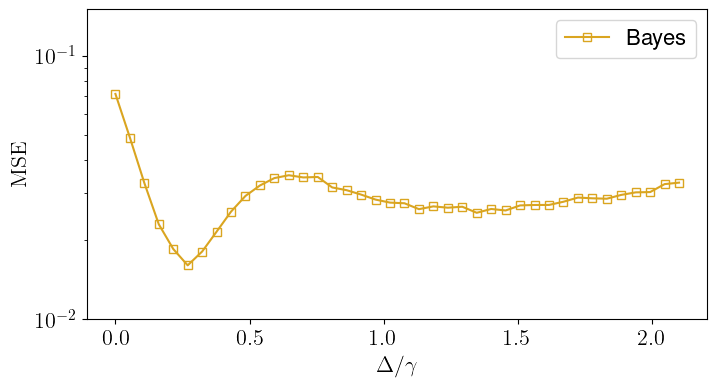

In [144]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### RNN model 

In [145]:
model=model=keras.models.load_model(datapath+"models/1D/model-RNN.h5", compile=False)

In [146]:
MSE_RNN, estimationsRNN = validate_model_1D_Delays(model)

100%|██████████| 40/40 [00:08<00:00,  4.62it/s]


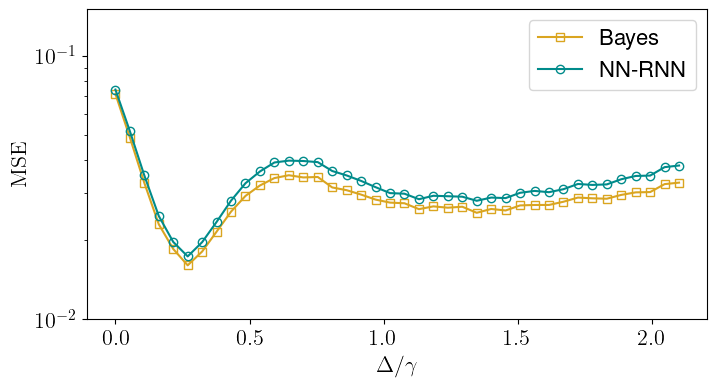

In [147]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN, 'o-',  label= "NN-RNN",color = "darkcyan",markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### Hist-Dense model

In [150]:
from paramest_nn.custom_layers import MyHistogramLayer_Sigmoid, histogram_sigmoid

Load model

In [151]:
modelname = 'model-Hist.h5'
modelHist=keras.models.load_model(datapath+f"models/1D/{modelname}", compile=False)

In [152]:
MSE_Hist, estimationsHist = validate_model_1D_Delays(modelHist)

100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


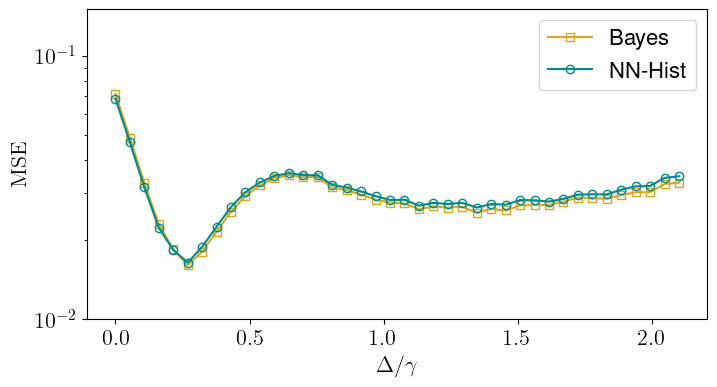

In [153]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Hist",color = "darkcyan",markerfacecolor='none')
#ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### Plotting all together

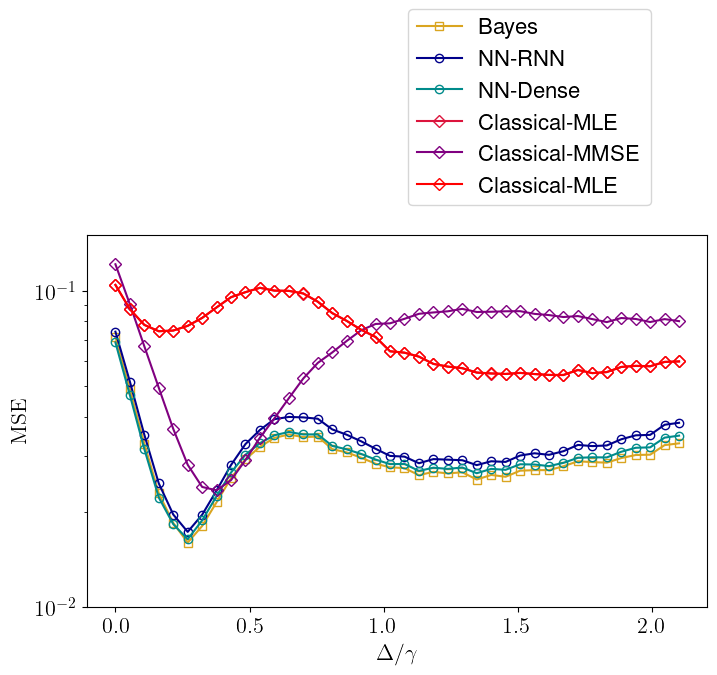

In [154]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical-MLE", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,MSE_Class_Bayes_mean, 'D-',  label= "Classical-MMSE", color = "purple",markerfacecolor='none')
ax.plot(deltalist,MSE_Class_Bayes_max, 'D-',  label= "Classical-MLE", color = "red",markerfacecolor='none')



ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

### Quantum Fisher information

Here we compute the Quantum Fisher information (QFI).
We follow the approach in [PRL 112, 170401 (2014)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.112.170401), where the expression for the QFI that we compute here can be found in Eq. (7).

In [155]:
def L_fun(omega, gamma, delta):
    'Returns Liouvillian for the two-level system model'
    return np.array([[0, 1j * omega, -1j * omega, gamma],
                    [1j * omega, -gamma/2 + 1j * delta, 0, -1j * omega],
                    [-1j * omega, 0, -gamma/2 - 1j * delta, 1j * omega],
                    [0, -1j * omega, 1j * omega, -gamma ]])


# Derivative of generalized Liouvillian with respect to theta_1
m1 = np.array([[0, 0, 0, 0],
               [0, 0, 0, 0],
               [0, 0, -1j, 0],
               [0, 0, 0, -1j]])

# Derivative of generalized Liouvillian with respect to theta_2
m2 = np.array([[0, 0, 0, 0],
               [0, 1j, 0, 0],
               [0, 0, 0, 0],
               [0, 0, 0, 1j]])

# Parameters
omega_sel = 1
gamma_sel = 1
delta_grid = deltalist

# Initialize derivatives list
der_list = []
identityVec = np.eye(2).flatten()

# Perform computation for each delta_sel
for delta_sel in delta_grid:
    umatrix = np.zeros((4,4), dtype = complex)

    Lsel = L_fun(omega_sel, gamma_sel, delta_sel)
    eigenvalues, eigenvectors = np.linalg.eig(Lsel)
    sorted_indices = np.argsort(eigenvalues.real)  # Sort eigenvalues in ascending order of real part
    eigenvalues = eigenvalues[sorted_indices]

    for i in range(4):
        umatrix[i] = eigenvectors[:, sorted_indices[i]]
    vmatrix = (np.linalg.inv(umatrix)).T

    # Normalized steady state
    rho_ss = umatrix[3] / (umatrix[3]@identityVec)
    sum1 = 0
    sum2 = 0
    for i in range(3):
        sum1 = sum1 + ((vmatrix[i] / eigenvalues[i]) @ m2 @ rho_ss) * umatrix[i]
        sum2 = sum2 + ((vmatrix[i] / eigenvalues[i]) @ m1 @ rho_ss) * umatrix[i]

    lambda_ij = (-m1@sum1 - m2@sum2)@ identityVec
    der_list.append(lambda_ij)  # Append the computed QFI

In [156]:
popGrid = np.asarray([compute_population_ss([omega, delta]) for delta in delta_grid])
Tgrid = 48/popGrid
QFI_list = 4*Tgrid*der_list

/Users/carlos/miniforge3/envs/paramest_nn/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


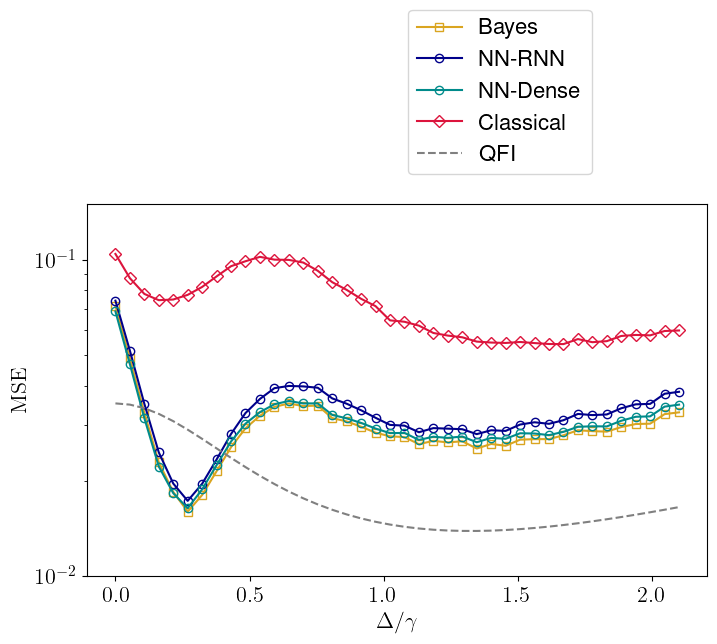

In [157]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,1/QFI_list, '--',  label= "QFI", color = "gray",markerfacecolor='none')



ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

### Fisher information for Photon Counting

Now we compute the Fisher information associated with the particular measurement that we are performing: Photon Counting.
For this, we use the expression in Eq. (5) in [Phys. Rev. A 87, 032115 (2013)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.032115)

In [158]:
def der2_trajectory(delta,tau_list):
    epsilon = 0.001
    logptheta1=np.log(compute_likelihood_analytical(delta,tau_list))
    logptheta2=np.log(compute_likelihood_analytical(delta+epsilon,tau_list))
    dptheta = (logptheta2-logptheta1)/epsilon
    return dptheta**2

def get_Fisher_Information_derivative(i_delta):
    trajectory_matrix = jumpsSetDelta[i_delta]
    delta_sel = deltalist[i_delta]
    der2_list = np.asarray([der2_trajectory(delta_sel,tau_list) for tau_list in trajectory_matrix])
    return np.mean(der2_list)


In [159]:
fisherIdelta = np.asarray(parallel_map(get_Fisher_Information_derivative,range(len(deltalist)), progress_bar=True))

10.0%. Run time:  10.36s. Est. time left: 00:00:01:33
20.0%. Run time:  10.40s. Est. time left: 00:00:00:41
30.0%. Run time:  10.46s. Est. time left: 00:00:00:24
40.0%. Run time:  10.57s. Est. time left: 00:00:00:15
50.0%. Run time:  20.74s. Est. time left: 00:00:00:20
60.0%. Run time:  20.82s. Est. time left: 00:00:00:13
70.0%. Run time:  20.87s. Est. time left: 00:00:00:08
80.0%. Run time:  20.91s. Est. time left: 00:00:00:05
90.0%. Run time:  21.00s. Est. time left: 00:00:00:02
100.0%. Run time:  25.82s. Est. time left: 00:00:00:00
Total run time:  25.82s


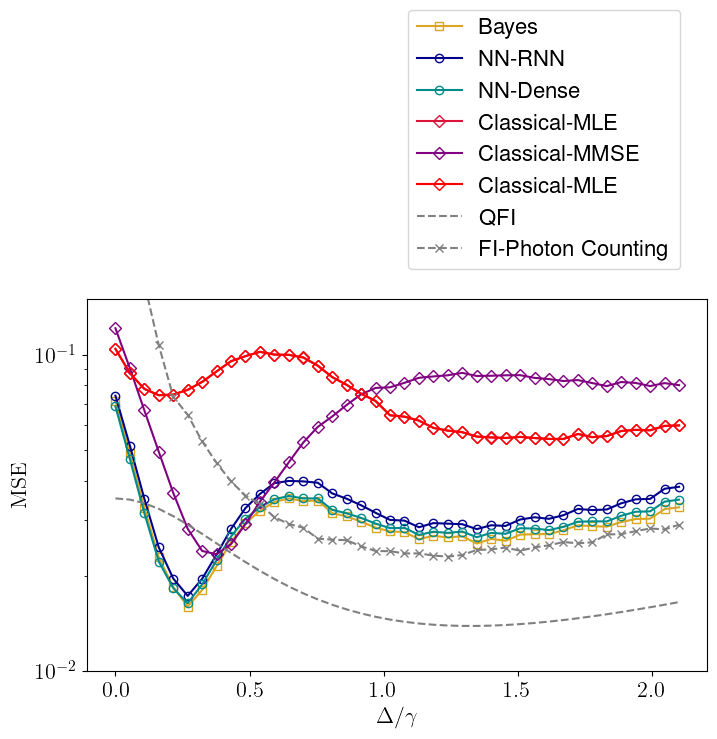

In [160]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical-MLE", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,MSE_Class_Bayes_mean, 'D-',  label= "Classical-MMSE", color = "purple",markerfacecolor='none')
ax.plot(deltalist,MSE_Class_Bayes_max, 'D-',  label= "Classical-MLE", color = "red",markerfacecolor='none')
ax.plot(deltalist,1/QFI_list, '--',  label= "QFI", color = "gray",markerfacecolor='none')
ax.plot(deltalist[1:],1/fisherIdelta[1:], 'x--',  label= "FI-Photon Counting", color = "gray",markerfacecolor='none')



ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.savefig("figures/fig3_b.pdf")

plt.show()

### Figure 3(a): Estimation scatter plots

In [164]:
delta_data = np.tile(deltalist, (nsets, 1)).T.flatten()

estim_data_RNN= estimationsRNN.flatten()
estim_data_Classical= estimationsClassical.flatten()
estim_data_Classical_Bayes_mean = estimationsClassicalBayes_mean.flatten()
estim_data_Classical_Bayes_max = estimationsClassicalBayes_max.flatten()
estim_data_Hist= estimationsHist.flatten()
estim_data_Bayes = estimationsBayes1D.flatten()

Scatter plots

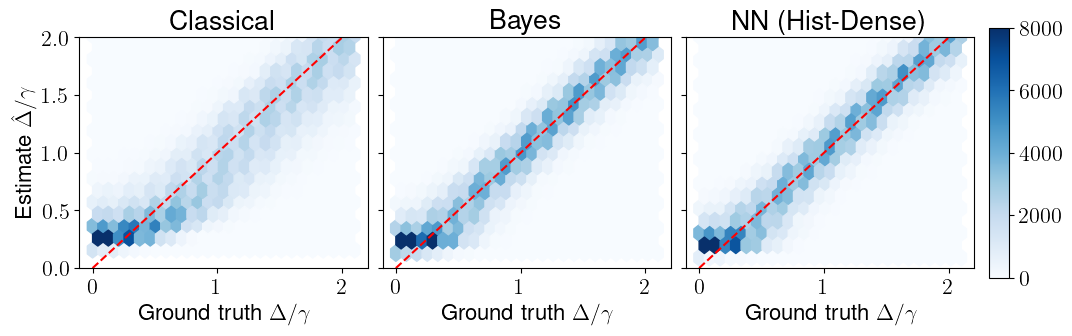

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import colors


cmap = 'Blues'
aspect=0.8
vmin =0
vmax = 8000

# Define the normalization object
norm = colors.Normalize(vmin=vmin, vmax=vmax)
gridsize = 25

# Set up figure and image grid
fig = plt.figure(figsize=(12,4))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

ax = grid[0]
hb = ax.hexbin(delta_data,estim_data_Classical_Bayes_mean, gridsize=gridsize, cmap = cmap, norm = norm)
ax.plot(delta_data,delta_data,'r--')
#cb = fig.colorbar(hb, ax=ax)
ax.set_xlabel("Ground truth $\Delta/\\gamma$"); ax.set_ylabel("Estimate $\hat\Delta/\gamma$")
ax.set_ylim(0.,2.)
ax.set_title('Classical')
ax.set_box_aspect(aspect)

ax = grid[1]
hb = ax.hexbin(delta_data,estim_data_Bayes, gridsize=gridsize, cmap = cmap, norm = norm)
#cb = fig.colorbar(hb, ax=ax)
ax.plot(delta_data,delta_data,'r--')
ax.set_xlabel("Ground truth $\Delta/\\gamma$"); ax.set_ylabel("Estimate $\hat\Delta/\gamma$")
ax.set_ylim(0.,2.)
ax.set_title('Bayes')
ax.set_box_aspect(aspect)

ax = grid[2]
hb = ax.hexbin(delta_data,estim_data_Hist, gridsize=gridsize, cmap = cmap, norm = norm)
#cb = fig.colorbar(hb, ax=ax)
ax.plot(delta_data,delta_data,'r--')
ax.set_xlabel("Ground truth $\Delta/\\gamma$"); ax.set_ylabel("Estimate $\hat\Delta/\gamma$")
ax.set_ylim(0.,2.)
ax.set_title('NN (Hist-Dense) ')
ax.set_box_aspect(aspect)
# Colorbar
ax.cax.colorbar(hb)
ax.cax.toggle_label(True)
plt.savefig("figures/fig3_a.pdf")

plt.show()

Bias plots

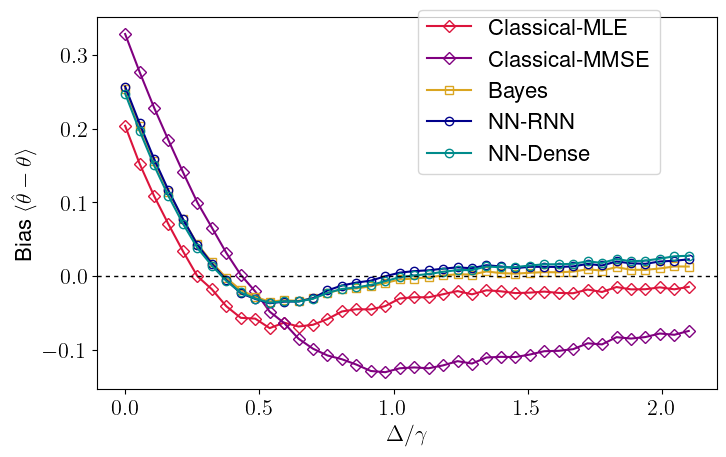

In [189]:
deltaPred_Classical_Bayes_max = [np.mean(estimations) for estimations in estimationsClassicalBayes_max]
vardeltaPred_Classical_Bayes_max = [np.var(estimations) for estimations in estimationsClassicalBayes_max]



deltaPred_Classical_Bayes_mean = [np.mean(estimations) for estimations in estimationsClassicalBayes_mean]
deltaPred_Bayes1D = [np.mean(estimations) for estimations in estimationsBayes1D]
deltaPred_RNN = [np.mean(estimations) for estimations in estimationsRNN]
deltaPred_Hist = [np.mean(estimations) for estimations in estimationsHist]



fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,deltaPred_Classical_Bayes_max-deltalist, 'D-',  label= "Classical-MLE", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,deltaPred_Classical_Bayes_mean-deltalist, 'D-',  label= "Classical-MMSE", color = "purple",markerfacecolor='none')

ax.plot(deltalist,deltaPred_Bayes1D-deltalist,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,deltaPred_RNN-deltalist,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,deltaPred_Hist-deltalist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("Bias $\langle \hat\\theta - \\theta \\rangle$"), 
ax.set_box_aspect(0.6)
ax.legend( bbox_to_anchor=(0.5, 1.05))
ax.axhline(0.,linewidth=1, color='black', dashes = [3., 3.])

#plt.savefig("figures/fig3_b.pdf")

plt.show()

### Turning model Hist-Dense into TensorFlow Lite model

Here, we demonstrate the process of reducing our trained Hist-Dense model into a [TensorFlow Lite (TFLite)](https://www.tensorflow.org/lite) model. 
This step holds significant importance in the realm of deploying machine learning models, especially on resource-constrained devices like mobile phones and embedded systems. 

TensorFlow Lite is a lightweight and optimized version of TensorFlow specifically designed for edge and mobile devices. By converting a model into TFLite format, we can achieve several advantages. First, TFLite models are more memory-efficient and have a smaller footprint, making them suitable for deployment on devices with limited resources. Second, TFLite models often exhibit faster inference times, crucial for real-time applications. Additionally, TFLite models are compatible with TensorFlow Lite Interpreter, which allows seamless integration with various platforms.



In [153]:
tflite_dir = datapath + 'models/1D/TFLite/'
create_directory(tflite_dir)
TFLITE_MODEL = tflite_dir+"modelHist.tflite"

Folder already exists.


In [150]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : modelHist(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(modelHist.inputs[0].shape, modelHist.inputs[0].dtype)
)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_MODEL, "wb").write(tflite_quant_model)

2023-09-01 16:30:54.241524: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-09-01 16:30:54.241621: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-01 16:30:54.513758: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-01 16:30:54.513768: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


92976

#### Load TFLite model

In [151]:
# Load TFLite model and see some details about input/output
tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

# Resize so that I can run inference on larger batches of data
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (nsets, 48))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (nsets, 48))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

#### Make predictions

In [154]:
# Prepare input data
nsets = 10000
taumax = 100
ndelta = len(deltalist)
nbins = modelHist.layers[0].input_shape[1] +1
bins = np.linspace(0,taumax,nbins)

jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]


MSE_list = []
varMSE_list = []
Estimation_list = []

for i_delta in tqdm(range(ndelta)): #Bucle sobre deltas

    delta=deltalist[i_delta]
    
    trajectory_matrix = jumpsSetDeltaList[i_delta]
    Delta_pred = np.zeros(nsets,float)

    # Set batch of data into input tensor
    tflite_interpreter.set_tensor(input_details[0]['index'], np.float32(trajectory_matrix))
    # Run inference
    tflite_interpreter.invoke()
    # Get prediction results
    Delta_pred = tflite_interpreter.get_tensor(output_details[0]['index'])

    MSE_NN = np.mean((Delta_pred-delta)**2)
    MSE_list.append(MSE_NN)

MSE_TFLite = np.array(MSE_list)

100%|██████████| 40/40 [00:52<00:00,  1.30s/it]


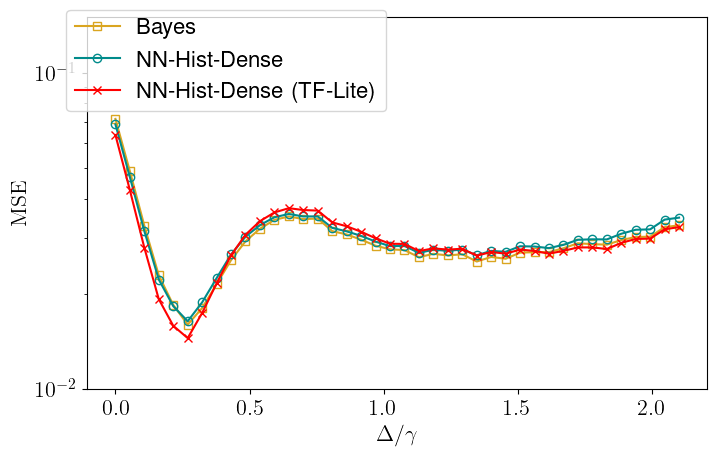

In [156]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Hist-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,MSE_TFLite, 'x-',  label= "NN-Hist-Dense (TF-Lite)",color = "red",markerfacecolor='none')



ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,0.15)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

## Figure 4: Benmachrking for 2D estimation

### Bayesian estimation

We work with data that has been saved in different batches (for parallelization). 
In our case, we have saved the validation trajectories in 10 different batches.
The number of batches was set in "1-Trajetories-generation.ipynb".

In [204]:
# Number of parameter pairs that were simulated for validation
nparams = 1600

# Number of trajectories that were simulated per parameter pair
nsets = 10000

# Number of batches in which the trajectories were divided 
nbatches = 10

# Number of trajectories per batch that correspond to a specific parameter pair
traj_per_param_pair = int(nsets/nbatches)

Load predictions

In [205]:
prediction_list = [np.load(
    datapath+f"results_cache/bayesian_estimation/2D/estimationBayes2DUltranest/uniform_2d_predictions_{idx_data}.npy"
) for idx_data in range(nbatches)]

We define some functions to handle this data and output the corresponding predictions

In [206]:
def select_prediction_param(i_param:int, pred_list_from_batch: list, traj_per_param_pair:int):
    '''
    Giving the list of predictions from a single batch, this function selects those corresponding to trajectories that were generated from a
    specific parameter pair, indexed by "i_param". This pair corresponds to the true value of the parameters, while this function will output the corresponding predictions.
    The number of predictions selected is given by "traj_per_param_pair".

    Parameters
    ----------
    i_param (int): Index characterizing the parameter-pair (Delta,Omega) of the trajectories to be analized.
    pred_list_from_batch (list): Full list of predictions from a single batch of data
    traj_per_param_pair (int): Number of trajectories corresponding to a single parameter-pair in each batch

    Returns
    ----------
    List of predictions corresponding only to the trajectories obtained from the parameter-pair with index "i_param"
    '''
    return list(pred_list_from_batch[(i_param)*traj_per_param_pair:(i_param+1)*traj_per_param_pair])

We now compare the predictions with the true parameters and compute the covariance matrix

In [207]:
MSE_Bayes2D = []

# Compute the covariance matrix

for i_param in tqdm(range(nparams)): # Loop over parameter-pairs

    delta=paramlist[i_param][0]
    omega = paramlist[i_param][1]
    params = np.array(paramlist[i_param])

    deltas_pred_mean_ALL = []
    omega_pred_mean_ALL = []

    for idx_batch in range(nbatches):
        omega_preds_mean, delta_preds_mean = prediction_list[idx_batch]
        
        deltas_pred_mean_ALL+=select_prediction_param(i_param, delta_preds_mean, traj_per_param_pair)
        omega_pred_mean_ALL+=select_prediction_param(i_param, omega_preds_mean, traj_per_param_pair)

    diff_delta=(deltas_pred_mean_ALL-params[0])
    diff_omega=(omega_pred_mean_ALL-params[1])
    
    MSE = np.mean(diff_delta**2) + np.mean(diff_omega**2)
    MSE_Bayes2D.append(MSE)

MSE_Bayes2D = np.asarray(MSE_Bayes2D)


100%|██████████| 1600/1600 [00:01<00:00, 1195.41it/s]


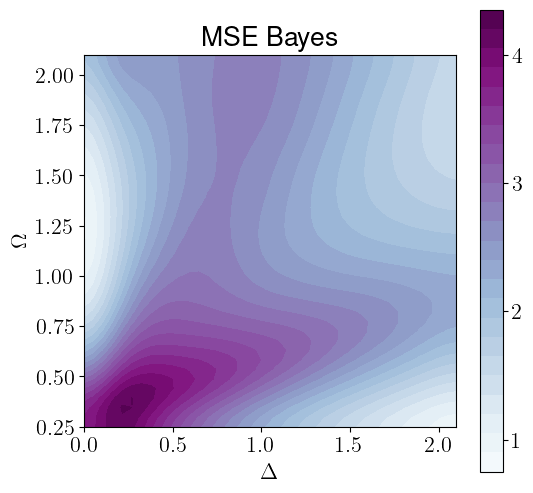

In [208]:
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter

levels = 4
deltaGrid = np.sort(np.unique(paramlist[:,0]))
OmegaGrid = np.sort(np.unique(paramlist[:,1]))
XX, YY = np.meshgrid(deltaGrid,OmegaGrid)

MSE_Bayes_matrix = MSE_Bayes2D.reshape(40,40)
MSE_Bayes_matrix = gaussian_filter(MSE_Bayes_matrix,sigma = 2)

fig, axis = plt.subplots(ncols=1,nrows=1,figsize=(6,6))

ax = axis
pcm=ax.contourf(XX,YY,-np.log(MSE_Bayes_matrix),cmap='BuPu',levels = 30)

cbar = fig.colorbar(pcm, ax=ax)
ticks = [1,2,3,4]
# Define your desired tick values
# Create a ticker object with your desired tick values
ticker_obj = ticker.FixedLocator(ticks)
# Set the ticker object for the colorbar
cbar.locator = ticker_obj
# Update the ticks and labels on the colorbar
cbar.update_ticks()
ax.set_box_aspect(1)
ax.set_title("MSE Bayes")
ax.set_xlabel("$\\Delta$")
ax.set_ylabel("$\\Omega$")



plt.show()

### Hist-Dense model

In [209]:
from paramest_nn.custom_layers import MyHistogramLayer_Sigmoid
modelname = "model-Hist-Dense-2D"
model=keras.models.load_model(datapath+"models/2D/"+modelname+'.h5', compile=False);

In [194]:
nsets = 10000 # Trajs. per parameter
path_results_model2D = datapath+f"results_cache/bayesian_estimation/2D/estimationNN/estimation-{modelname}"
isMSEfile=os.path.isfile(path_results_model2D+".npy")

if isMSEfile:
    print("We found cached results for the validation of the model. Loading.")
    MSE_NN_2D = np.load(path_results_model2D+".npy")
else:
    print("We did not found cached results for the validation of the model. Computing.")
    MSE_NN_2D = validate_model_2D_Delays(model,nsets = nsets,jumpsSetParams=jumpsSetParams,paramlist=paramlist, progress_bar = True)
    np.save(path_results_model2D,MSE_NN_2D) 

We found cached results for the validation of the model. Loading.


In [203]:
import matplotlib.ticker as ticker

levels = [-3.5, -2.5, -1.5,-0.5]
cmap = plt.get_cmap('BuPu').reversed()

# Define the matrices to plot
MSE_Bayes_matrix = MSE_Bayes2D.reshape(40,40)
MSE_Bayes_matrix = gaussian_filter(MSE_Bayes_matrix,sigma = 2)
MSE_NN_matrix = MSE_NN_2D.reshape(40,40)
MSE_NN_matrix = gaussian_filter(MSE_NN_matrix,sigma = 2)

fig, axis = plt.subplots(ncols=3,nrows=1,figsize=(18,6))

ax = axis[0]
pcm=ax.contourf(XX,YY,np.log(MSE_Bayes_matrix),cmap=cmap,levels = 30)

cbar = fig.colorbar(pcm, ax=ax)
ticks = [-4,-3,-2,-1]
# Define your desired tick values
# Create a ticker object with your desired tick values
ticker_obj = ticker.FixedLocator(ticks)
# Set the ticker object for the colorbar
cbar.locator = ticker_obj
# Update the ticks and labels on the colorbar
cbar.update_ticks()



ax.set_box_aspect(1)
ax.set_title("MSE Bayes")
ax.set_xlabel("$\\Delta$")
ax.set_ylabel("$\\Omega$")



ax = axis[1]
pcm=ax.contourf(XX,YY,np.log(MSE_NN_matrix),cmap=cmap,levels = 30)
#fig.colorbar(pcm, ax=axis)
ax.set_box_aspect(1)
ax.set_title("MSE NN")
ax.set_xlabel("$\\Delta$")
ax.set_ylabel("$\\Omega$")
cbar = fig.colorbar(pcm, ax=ax)
ticker_obj = ticker.FixedLocator(ticks)
cbar.locator = ticker_obj
cbar.update_ticks()

ax = axis[2]
pcm=ax.contour(XX,YY,np.log(MSE_Bayes_matrix),colors='crimson',levels = levels)
ax.clabel(pcm, inline=True, fontsize=15)
pcm=ax.contour(XX,YY,np.log(MSE_NN_matrix),colors='steelblue',levels = levels)
ax.clabel(pcm, inline=True, fontsize=15)
ax.set_box_aspect(1)
ax.set_xlabel("$\\Delta$")
ax.set_ylabel("$\\Omega$")

plt.savefig("figures/fig4.pdf")

cbar = fig.colorbar(pcm, ax=ax)
ticker_obj = ticker.FixedLocator(ticks)
cbar.locator = ticker_obj
cbar.update_ticks()
plt.show()

NameError: name 'MSE_Bayes2D' is not defined

### Classical Bayesian estimation

In [226]:
def compute_PT_param_list(T,param_list):
    ''' 
    Returns estimator based on the mean of the posterior distribution (minimum mean square error (MMSE) estimator)
    '''
    # PT_Delta_list = np.asarray([calculate_PT(T,N,gamma,Omega, Delta) for Delta in Delta_list])
    PT_param_list = np.asarray([calculate_Ptau_gaussian(T/48, param[0], gamma=1., Omega= param[1], N=48) for param in param_list]) 
    norm = np.sum(PT_param_list)
    return PT_param_list/norm

Define Bayes parameter grid

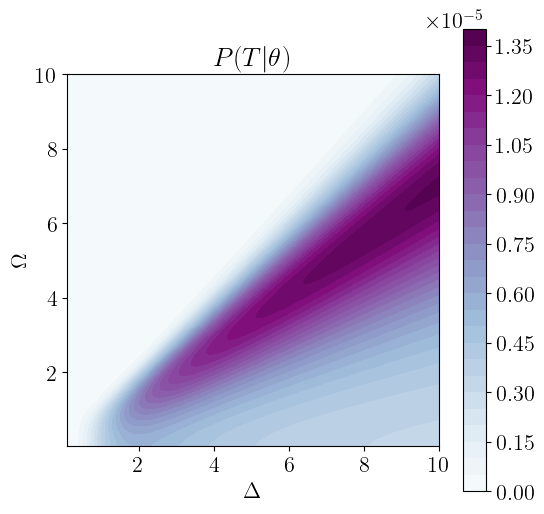

In [258]:
ndelta = 500
nomega = 500

deltamin = 0.1
deltamax = 10.

omegamin =0.01
omegamax = 10.

deltagrid = np.linspace(deltamin,deltamax,ndelta)
omegagrid = np.linspace(omegamin,omegamax,nomega)

def gen_param_list(array1,array2):
    return np.array(np.meshgrid(array1,array2)).T.reshape(-1,2)

param_grid = gen_param_list(deltagrid,omegagrid)
XX, YY = np.meshgrid(deltagrid,omegagrid)


Tfin = 120.
PT_param_list = compute_PT_param_list(Tfin,param_grid).reshape(ndelta,nomega)

fig, axis = plt.subplots(ncols=1,nrows=1,figsize=(6,6))

ax = axis
pcm=ax.contourf(XX,YY,PT_param_list,cmap='BuPu',levels = 30)

cbar = fig.colorbar(pcm, ax=ax)
ticks = [1,2,3,4]
cbar.update_ticks()
ax.set_box_aspect(1)
ax.set_title("$P(T|\\theta)$")
ax.set_xlabel("$\\Delta$")
ax.set_ylabel("$\\Omega$")

plt.show()


In [ ]:
def MMSE_MLE_estimator_2D(T,Omega, param_list, gamma =1,  N=48, return_prob = False):
    ''' 
    Returns estimator based on the mean of the posterior distribution (minimum mean square error (MMSE) estimator)
    '''
    # PT_Delta_list = np.asarray([calculate_PT(T,N,gamma,Omega, Delta) for Delta in Delta_list])
    PT_param_list = np.asarray([calculate_Ptau_gaussian(T/48, param[0], gamma=1., Omega= param[1], N=48) for param in param_list]) 
    norm = np.sum(PT_param_list)
 
    #Posterior
    PDelta = PT_param_list/norm
    param_mean = np.trapz(PDelta*Delta_list,Delta_list)
    Delta_max = Delta_list[np.argmax(PDelta)]
    
    if return_prob==False:
        return Delta_mean, Delta_max
    else:
        return Delta_mean, Delta_max, PDelta

In [196]:
paramlist

array([[0.        , 0.25      ],
       [0.        , 0.2974359 ],
       [0.        , 0.34487179],
       ...,
       [2.1       , 2.00512821],
       [2.1       , 2.0525641 ],
       [2.1       , 2.1       ]])

## Figure 5: Robustness against noise

### Noise in x-train

- This evaluation requires a populated `data/models/1D/noise-x-train` folder. 

- This folder is populated by running the notebook `1-Training`

- The array of $\sigma$ considered here should match the one used to train the models in `data/models/1D/noise-x-train`

In [170]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

For this test, we select a particular value of delta from the validation set.


In [171]:
i_delta = 5 
delta = deltalist[i_delta]
trajectory_matrix = jumpsSetDelta[i_delta]

We loop over $\sigma$, addding noise to the validation trajectories. We make predictions using the corresponding model trained with data with the same noise, and also make a Bayesian estimation with a model that does not account for noise.

In [172]:
mse_sigma = []
mse_sigma_NN = []
estimate_Bayes_array = []
estimate_NN_array = []
varMSE_Bayes_array = []
varMSE_NN_array = []

seed = 1
# nsets can be as high as 10k (the total number of validation trajectories per delta value)
nsets = 1000

for sigma in tqdm(sigma_list):
    noise = np.random.default_rng(seed).normal(0.,sigma, trajectory_matrix.shape)
    trajectory_matrix_noise = ((trajectory_matrix + noise).clip(min=1E-3))[:nsets]

    estimate_array = np.array(parallel_map(get_estimates,trajectory_matrix_noise))
    estimate_Bayes_array.append(estimate_array)
    est_mean_anal = estimate_array[:,0]
    mse_mean = np.mean((est_mean_anal - delta)**2)
    varMSE = np.var((est_mean_anal - delta)**2)
    mse_sigma.append(mse_mean)
    varMSE_Bayes_array.append(varMSE)

    model=keras.models.load_model(datapath+f"models/1D/noise-x-train/model_best_Hist-sigma_{sigma}.hdf5",compile=False)
    estimate_array= np.asarray(model(trajectory_matrix_noise)).flatten()
    estimate_NN_array.append(estimate_array)

    mse = np.mean((estimate_array - delta)**2)
    varMSE = np.var((estimate_array - delta)**2)
    mse_sigma_NN.append(mse)
    varMSE_NN_array.append(varMSE)

mse_sigma = np.asarray(mse_sigma)
mse_sigma_NN = np.asarray(mse_sigma_NN)
estimate_NN_array = np.asarray(estimate_NN_array)
estimate_Bayes_array = np.asarray(estimate_Bayes_array)
varMSE_Bayes_array = np.asarray(varMSE_Bayes_array)
varMSE_NN_array = np.asarray(varMSE_NN_array)


100%|██████████| 30/30 [07:06<00:00, 14.20s/it]


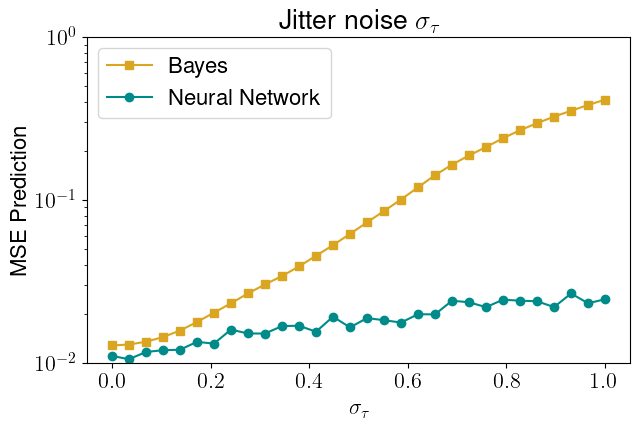

In [173]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(sigma_list,mse_sigma, 's-',label= 'Bayes', color = "goldenrod")
ax.plot(sigma_list,mse_sigma_NN,'o-', label= 'Neural Network', color = "darkcyan")
ax.set_box_aspect(0.6)
ax.set_ylim(0.01,1)
plt.xlabel("$\\sigma_\\tau$"); plt.ylabel("MSE Prediction"); 
plt.title('Jitter noise $\sigma_\\tau$')
plt.yscale('log')
plt.legend()
plt.savefig('figures/fig_5_a.pdf')
plt.show()

### Noise in the y-train

- This evaluation requires a populated `data/models/1D/noise-y-train` folder. 

- This folder is populated by running the notebook `1-Training`

- The array of $\sigma$ considered here should match the one used to train the models in `data/models/1D/noise-y-train`

In [174]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

For this test, we select a particular value of delta from the validation set.


In [175]:
i_delta = 5 
delta = deltalist[i_delta]
trajectory_matrix = jumpsSetDelta[i_delta]

We compute the Bayesian reference

In [176]:
nsetsBayes = 1000
estimate_array = np.array(parallel_map(get_estimates,trajectory_matrix[:nsetsBayes]))
est_mean_anal = estimate_array[:,0]
mse_Bayes = np.mean((est_mean_anal - delta)**2)

We loop over $\sigma$, evaluating the predictions made with noise in the target data. 

In [177]:
mse_sigma = []
mse_sigma_NN = []
varMSE_sigma_NN = []
estimate_Calibration_Array = []
estimate_NN_array = []

for sigma in tqdm(sigma_list):
    noise = np.random.default_rng(seed).normal(0.,sigma,nsets)

    # This array is replicates the noise in the training. 
    estimate_array = delta + noise
    estimate_Calibration_Array.append(estimate_array)
    mse_mean = np.mean((estimate_array - delta)**2)
    mse_sigma.append(mse_mean)

    model=keras.models.load_model(datapath+f"models/1D/noise-y-train/model_best_Hist-sigma_{sigma}.hdf5", compile=False)
    estimate_array= np.asarray(model(trajectory_matrix)).flatten()
    estimate_NN_array.append(estimate_array)

    mse = np.mean((estimate_array - delta)**2)
    varMSE = np.var((estimate_array - delta)**2)
    mse_sigma_NN.append(mse)
    varMSE_sigma_NN.append(varMSE)

mse_sigma = np.asarray(mse_sigma)
mse_sigma_NN = np.asarray(mse_sigma_NN)
estimate_NN_array = np.asarray(estimate_NN_array)
estimate_Calibration_Array = np.asarray(estimate_Calibration_Array)
varMSE_sigma_NN = np.asarray(varMSE_sigma_NN)

  0%|          | 0/30 [00:00<?, ?it/s]


OSError: No file or directory found at ../data/models/1D/noise-y-train/model_best_Hist-sigma_0.0.hdf5

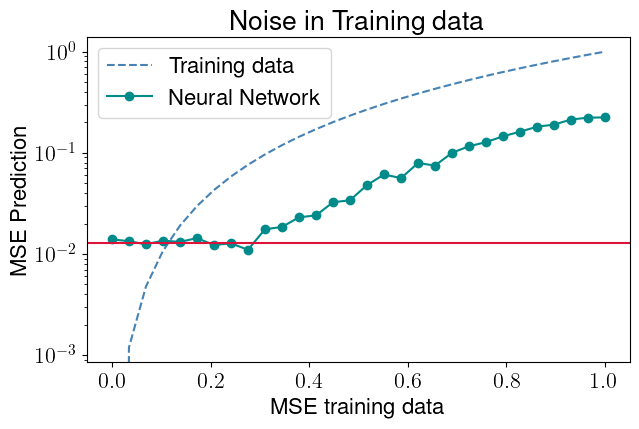

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(sigma_list, sigma_list**2, '--',color='steelblue', label="Training data")
ax.plot(sigma_list,mse_sigma_NN,'o-', label= 'Neural Network', color = "darkcyan")

ax.axhline(mse_Bayes, color='crimson')
ax.set_box_aspect(0.6)
plt.xlabel("MSE training data"); plt.ylabel("MSE Prediction"); 
plt.title('Noise in Training data')
plt.yscale('log')
plt.legend()
plt.savefig('figures/fig_5_b.pdf')
plt.show()